<a href="https://colab.research.google.com/github/Vridhi-Wadhawan/deep-learning-models-in-practice/blob/main/03_spam_classification_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam Classification Using Recurrent Neural Networks

## Overview

This project builds an end-to-end spam detection system for SMS messages using a Recurrent Neural Network (LSTM).

It mirrors a real-world production scenario where model selection depends on asymmetric error costs rather than accuracy alone.

The focus is on:
- sequence-aware text representation
- model capacity vs generalisation trade-offs
- metric-driven model selection for real-world spam filtering

## Environment Setup

In [ ]:
import os, glob, re
import kagglehub
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from itertools import product
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import TensorDataset, DataLoader

## Data Ingestion

In [ ]:
def load_sms_dataset(ref="team-ai/spam-text-message-classification"):
    path = kagglehub.dataset_download(ref)
    csv = glob.glob(os.path.join(path, "*.csv"))[0]
    df  = pd.read_csv(csv)[["Message", "Category"]]
    df.columns = ["text", "label"]
    output_path = "/content/spam_data.csv"
    df.to_csv(output_path, index=False)
    print(f"Saved dataframe to: {output_path}")
    print(df.head())
    print(df.info())
    return df

In [ ]:
df_sms = load_sms_dataset()

100%|██████████| 208k/208k [00:00<00:00, 50.1MB/s]

Extracting files...
Saved dataframe to: /content/spam_data.csv
                                                text label
0  Go until jurong point, crazy.. Available only ...   ham
1                      Ok lar... Joking wif u oni...   ham
2  Free entry in 2 a wkly comp to win FA Cup fina...  spam
3  U dun say so early hor... U c already then say...   ham
4  Nah I don't think he goes to usf, he lives aro...   ham
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   label   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


**Observations**
- Dataset contains 5,572 SMS messages labeled as either ham (i.e, not spam) or spam.
- Columns in the data set are:
  - text: raw message content
  - label: class label (ham or spam)
- There are no missing values and both columns are non‑null and of type object.
- Spam messages frequently contain promotional language, numeric patterns, and repetitive structures that are well-suited to sequence models.
- The binary target will be mapped to integers (ham = 0, spam = 1) for model training


## Text Preprocessing & Vocabulary Construction

In [ ]:
def preprocess_texts(df, min_freq=1):
    # clean whitespace & punctuation, lowercase
    df["tokens"] = (
        df["text"]
          .str.lower()
          .str.replace(r"[^a-z0-9\s]", "", regex=True)
          .str.split()
    )
    df["y"] = df["label"].map({"ham":0, "spam":1})

    # build vocab
    counter = Counter(w for sent in df["tokens"] for w in sent)
    vocab   = {"<PAD>":0, "<UNK>":1}
    for w,f in counter.items():
        if f >= min_freq:
            vocab[w] = len(vocab)
    return df, vocab

In [ ]:
df_sms, vocab = preprocess_texts(df_sms)

In [ ]:
print(df_sms.head())
print(df_sms.info())

                                                text label  \
0  Go until jurong point, crazy.. Available only ...   ham   
1                      Ok lar... Joking wif u oni...   ham   
2  Free entry in 2 a wkly comp to win FA Cup fina...  spam   
3  U dun say so early hor... U c already then say...   ham   
4  Nah I don't think he goes to usf, he lives aro...   ham   

                                              tokens  y  
0  [go, until, jurong, point, crazy, available, o...  0  
1                     [ok, lar, joking, wif, u, oni]  0  
2  [free, entry, in, 2, a, wkly, comp, to, win, f...  1  
3  [u, dun, say, so, early, hor, u, c, already, t...  0  
4  [nah, i, dont, think, he, goes, to, usf, he, l...  0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   label   5572 non-null   object
 2   tokens  5572 non-null   

**Observations**
- Text is normalised via lowercasing and removal of non-alphanumeric characters, followed by word-level tokenisation.
- Built vocabulary from all tokens with minimum frequency threshold = 1.
- Special tokens:
  - <PAD> (0) for sequence padding
  - <UNK> (1) for unknown words
- Including <UNK> ensures robustness to unseen words
- Vocabulary size directly impacts embedding matrix dimensions and model capacity.
- Final DataFrame includes:
  - tokens: list of cleaned words
  - y: integer label (0=ham, 1=spam)

## Sequence Encoding & Data Loaders

In [ ]:
def encode_and_pad(tokens, vocab, max_len=50):
    ids = [vocab.get(w, 1) for w in tokens]
    if len(ids) < max_len:
        ids += [0]*(max_len-len(ids))
    else:
        ids = ids[:max_len]
    return ids

In [ ]:
max_len = 50
# building an int‐typed array of token‐IDs
x = np.array([encode_and_pad(tokens, vocab, max_len) for tokens in df_sms["tokens"]], dtype=np.int64)
# Pulling the integer label series created in preprocess_texts
y = df_sms["y"].astype(np.int64).values

In [ ]:
print(x.shape, y.shape)

(5572, 50) (5572,)


In [ ]:
# Train/Test Split
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.2, random_state=38, stratify=y)

In [ ]:
def get_loader(x, y, batch_size=64, shuffle=True):
    xt = torch.tensor(x, dtype=torch.long)
    yt = torch.tensor(y.reshape(-1,1), dtype=torch.float32)
    ds = TensorDataset(xt, yt)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

In [ ]:
train_loader = get_loader(xtrain, ytrain.astype(int))
test_loader  = get_loader(xtest, ytest.astype(int), shuffle=False)

In [ ]:
print(train_loader.dataset[0])
print(test_loader.dataset[0])

(tensor([1952,  101,    9, 1953, 1954,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]), tensor([0.]))
(tensor([4609, 3912, 1730, 4610,  358, 4611,    9,  112,  341,  150,  623,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]), tensor([0.]))


**Observations**
- Each token sequence encoded into integer IDs using the vocabulary
- Fixed‑length sequences allow efficient batch processing in the RNN.
- Fixed sequence length is 50 tokens.
  - Shorter sequences padded with <PAD> (0).
  - Longer sequences truncated.
- Padding index (0) is ignored by the embedding layer, preventing artificial sequence length from influencing learned representations.
- Created NumPy arrays:
  - x: shape (5572, 50), integer token IDs.
  - y: binary labels.
- Train/test split: 80/20 stratified to preserve spam/ham ratio and balanced class distribution in both sets.
- PyTorch DataLoaders:
  - Batch size: 64.
  - Shuffling enabled for training set.



## Model Architecture

In [ ]:
class SpamRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim,
                 n_layers=1, bidir=False, dropout=0.3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm  = nn.LSTM(
            embed_dim, hidden_dim, num_layers=n_layers,
            batch_first=True, bidirectional=bidir,
            dropout=dropout if n_layers>1 else 0
        )
        factor = 2 if bidir else 1
        self.fc    = nn.Linear(hidden_dim*factor, 1)
        self.drop  = nn.Dropout(dropout)

    def forward(self, x):
        emb, _ = self.lstm(self.embed(x))
        h = emb[:, -1, :]            # last timestep
        return self.fc(self.drop(h))

**Observations**
- Embedding layer includes:
  - Input: vocabulary size
  - Output: embedding dimension (varies in experiments: 32 or 64).
  - padding_idx=0 to ignore <PAD> tokens
- LSTM captures sequential dependencies in text, useful for detecting spam patterns.
- LSTM layer:
  - Hidden units: 64 or 128
  - Layers: 1 or 2
  - Dropout applied if n_layers > 1
  - Optionally Bidirectional
- Bidirectional option allows context from both past and future tokens
- Fully connected layer:
  - Input: hidden state(s) from last time step.
  - Output: single logit for binary classification.
- Dropout layer before final output to reduce overfitting.
- Embedding + LSTM + FC is a standard, effective architecture for text classification.
- The final hidden state is used for classification, aligning with the assumption that spam-relevant signals accumulate across the full sequence.



## Training Loop & Evaluation Metrics

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    for xb, yb in loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

In [ ]:
def eval_model(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb)
            p = (torch.sigmoid(logits)>=0.5).int().cpu().numpy()
            preds.extend(p.ravel())
            trues.extend(yb.cpu().numpy().ravel())
    return (
        accuracy_score(trues, preds),
        precision_score(trues, preds, zero_division=0),
        recall_score(trues, preds),
        f1_score(trues, preds))

In [ ]:
def run_training(model, train_loader, test_loader,
                 lr=1e-3, n_epochs=10, weight_decay=0):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=lr, weight_decay=weight_decay)
    history = []
    for epoch in range(1, n_epochs+1):
        train_one_epoch(model, train_loader, criterion, optimizer)
        acc, prec, rec, f1 = eval_model(model, test_loader)
        history.append({"epoch":epoch, "acc":acc,
                        "prec":prec, "rec":rec, "f1":f1})
    return history

## Hyperparameter Exploration

- Parameters varied in the sweep:
  - Embedding dimension: 32, 64
  - Hidden dimension: 64, 128
  - LSTM layers: 1, 2
  - Dropout: 0.2, 0.3
  - Learning rate: 0.001, 0.0005
  - Bidirectional: True / False
  - Batch size: 64

In [ ]:
param_grid = {
    "embed_dim":  [32, 64],
    "hidden_dim": [64, 128],
    "n_layers":   [1, 2],
    "bidir":      [False, True],
    "dropout":    [0.2, 0.3],
    "lr":         [1e-3, 5e-4],
    "batch_size": [64]}

In [ ]:
results = []
for cfg in product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), cfg))

    # prepare model & loaders
    model = SpamRNN(
        vocab_size=len(vocab),
        embed_dim=params["embed_dim"],
        hidden_dim=params["hidden_dim"],
        n_layers=params["n_layers"],
        bidir=params["bidir"],
        dropout=params["dropout"]
    )
    train_loader = get_loader(xtrain, ytrain, batch_size=params["batch_size"])
    test_loader  = get_loader(xtest, ytest, batch_size=params["batch_size"], shuffle=False)

    # train & eval
    hist = run_training(
        model, train_loader, test_loader,
        lr=params["lr"], n_epochs=5
    )
    # record final epoch metrics
    final = hist[-1]
    results.append({**params, **final})

In [ ]:
# display top 5 by f1
df_res = pd.DataFrame(results).sort_values("f1", ascending=False).head(5)
print(df_res)

    embed_dim  hidden_dim  n_layers  bidir  dropout      lr  batch_size  \
59         64         128         2  False      0.3  0.0005          64   
57         64         128         2  False      0.2  0.0005          64   
51         64         128         1  False      0.3  0.0005          64   
47         64          64         2   True      0.3  0.0005          64   
41         64          64         2  False      0.2  0.0005          64   

    epoch       acc      prec       rec        f1  
59      5  0.960538  0.843137  0.865772  0.854305  
57      5  0.964126  0.957983  0.765101  0.850746  
51      5  0.960538  0.900763  0.791946  0.842857  
47      5  0.961435  0.941667  0.758389  0.840149  
41      5  0.957848  0.875000  0.798658  0.835088  


### Best F1-Optimised Configuration
  - Embedding dim: 64
  - Hidden dim: 128
  - LSTM layers: 2
  - Dropout: 0.3
  - LR: 0.0005
  - No bidirectionality
  - Accuracy of 96.05%, Precision of 0.84, Recall of 0.87
  
  This configuration offered a balanced trade‑off between catching spam and avoiding false positives.

In [ ]:
# display top 5 by recall
df_res = pd.DataFrame(results).sort_values("rec", ascending=False).head(5)
print(df_res)

    embed_dim  hidden_dim  n_layers  bidir  dropout      lr  batch_size  \
50         64         128         1  False      0.3  0.0010          64   
42         64          64         2  False      0.3  0.0010          64   
45         64          64         2   True      0.2  0.0005          64   
59         64         128         2  False      0.3  0.0005          64   
19         32         128         1  False      0.3  0.0005          64   

    epoch       acc      prec       rec        f1  
50      5  0.944395  0.735135  0.912752  0.814371  
42      5  0.879821  0.529644  0.899329  0.666667  
45      5  0.928251  0.678756  0.879195  0.766082  
59      5  0.960538  0.843137  0.865772  0.854305  
19      5  0.943498  0.765432  0.832215  0.797428  


### Best Recall-Optimised Configuration
  - Embedding dim: 64
  - Hidden dim: 128
  - LSTM layers: 1
  - Dropout: 0.3
  - LR: 0.001
  - No bidirectionality
  - Accuracy of 94.44%, Precision of 0.735

This configuration prioritised spam capture, correctly identifying over 91% of spam messages, but flagged more legitimate messages as spam.

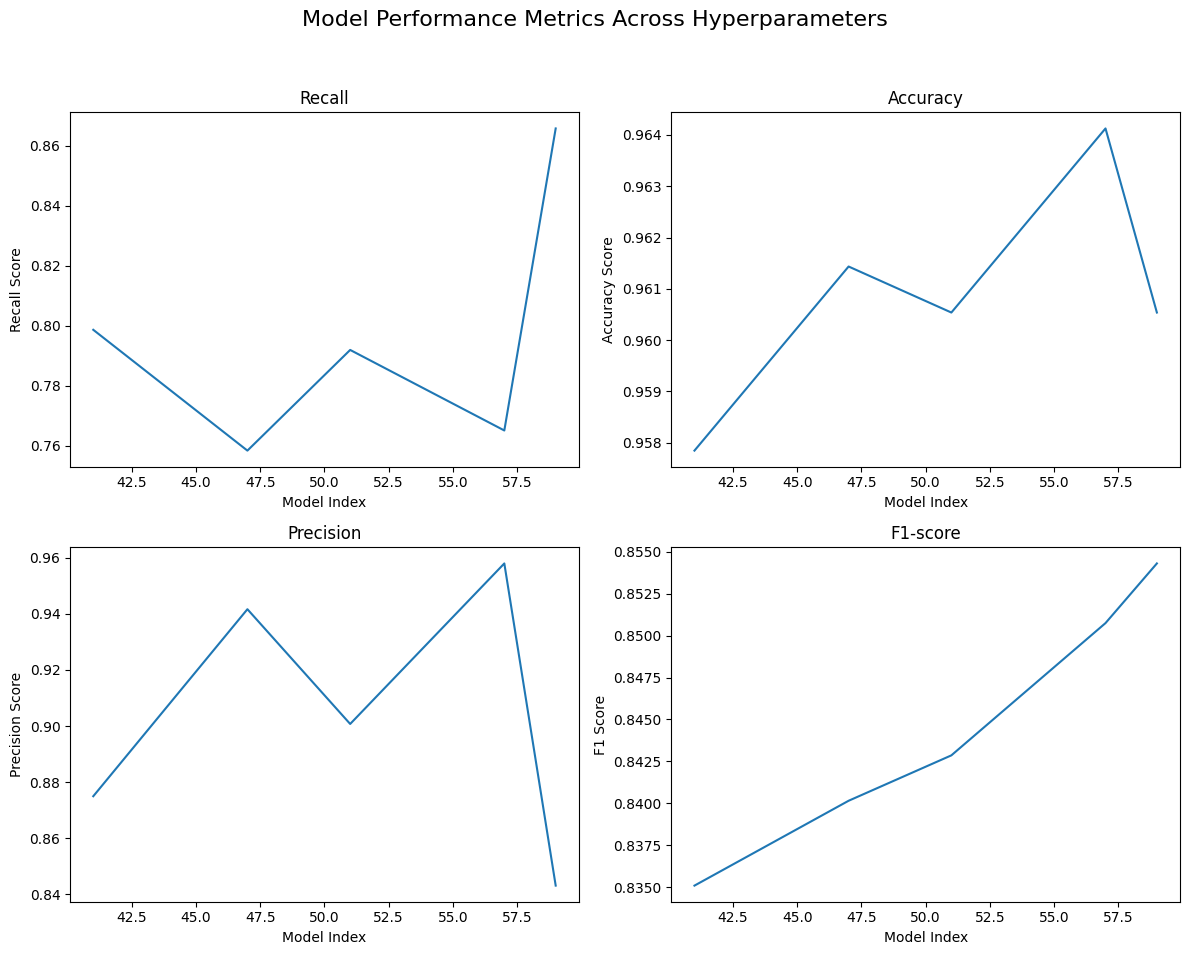

In [ ]:
# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Model Performance Metrics Across Hyperparameters', fontsize=16)

# Plot Recall
axes[0, 0].plot(df_res.index, df_res['rec'])
axes[0, 0].set_title('Recall')
axes[0, 0].set_xlabel('Model Index')
axes[0, 0].set_ylabel('Recall Score')

# Plot Accuracy
axes[0, 1].plot(df_res.index, df_res['acc'])
axes[0, 1].set_title('Accuracy')
axes[0, 1].set_xlabel('Model Index')
axes[0, 1].set_ylabel('Accuracy Score')

# Plot Precision
axes[1, 0].plot(df_res.index, df_res['prec'])
axes[1, 0].set_title('Precision')
axes[1, 0].set_xlabel('Model Index')
axes[1, 0].set_ylabel('Precision Score')

# Plot F1-score
axes[1, 1].plot(df_res.index, df_res['f1'])
axes[1, 1].set_title('F1-score')
axes[1, 1].set_xlabel('Model Index')
axes[1, 1].set_ylabel('F1 Score')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

**Observations**
- Models with hidden dimension of 128 consistently appeared in the top results for both F1 and recall which suggests that increased capacity helps capture richer spam/ham patterns.
- Bidirectionality appeared only once in the top 5 for each metric which indicates it is not a key driver of performance here.
- The choice between F1‑optimised and recall‑optimised models depends on the application:
  - F1‑optimised → balanced performance, fewer false positives.
  - Recall‑optimised → maximum spam capture, tolerates more false positives.

In real-world spam filtering, false negatives (missed spam) are often more costly than false positives; therefore, the recall-optimised model was selected as the final candidate, achieving over 91% spam detection while maintaining acceptable precision.

